In [2]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

cuda:0


In [3]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0,90)),
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

train_data_path = 'DataSet/train/'
test_data_path = 'DataSet/test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
dir_aug = torchvision.datasets.ImageFolder(train_data_path,transform=augmentation)
dir_train = torch.utils.data.ConcatDataset((dir_train,dir_aug))


train_data = torch.utils.data.DataLoader(dir_train,batch_size=128,shuffle=True,num_workers=8)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=8)
len(train_data.dataset)

1114

In [4]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [5]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [6]:
from torch import nn
import torchvision.models as models

cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    param.requires_grad=False
num_ftrs = cnn.fc.in_features
cnn.fc = nn.Linear(num_ftrs, 2)
cnn.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [8]:
epochs = 75
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
loss_best_model = 1e9

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < loss_best_model:
        loss_best_model = val_loss_per_epoch
        model_path = 'SavedModels/test_model'
        torch.save(cnn.state_dict(),model_path)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.6965011755625407
Val Loss: 0.6675061702728271
Train Accuracy: 0.48384201526641846
Val Accuracy: 0.6714285612106323

Starting epoch 2
Train Loss: 0.6380742324723138
Val Loss: 0.5908897995948792
Train Accuracy: 0.7378815412521362
Val Accuracy: 0.8785714507102966

Starting epoch 3
Train Loss: 0.5717591908242967
Val Loss: 0.5231653809547424
Train Accuracy: 0.85996413230896
Val Accuracy: 0.9071428775787354

Starting epoch 4
Train Loss: 0.5079348915153079
Val Loss: 0.48456929326057435
Train Accuracy: 0.906642735004425
Val Accuracy: 0.9428571462631226

Starting epoch 5
Train Loss: 0.462236440844006
Val Loss: 0.43384537696838377
Train Accuracy: 0.9308797121047974
Val Accuracy: 0.9357143044471741

Starting epoch 6
Train Loss: 0.4208161665333642
Val Loss: 0.3972511351108551
Train Accuracy: 0.9515260457992554
Val Accuracy: 0.9428571462631226

Starting epoch 7
Train Loss: 0.3817426496081882
Val Loss: 0.3836733877658844
Train Accuracy: 0.9533213973045349
Val Accuracy:

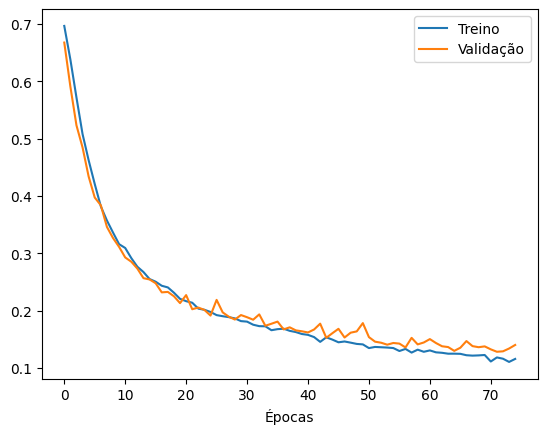

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

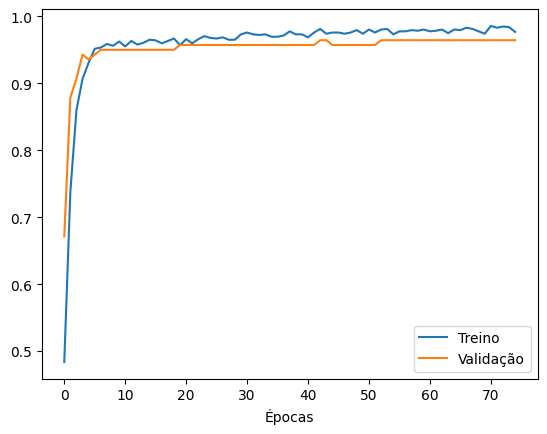

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [11]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        70
         1.0       0.96      0.97      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [12]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047])
    ]
)

dir_val = torchvision.datasets.ImageFolder('Teste',transform=transform)
val_data = torch.utils.data.DataLoader(dir_val,batch_size=32,shuffle=False,num_workers=0)

In [13]:
from sklearn.metrics import classification_report

cnn.train(False)

for data in val_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = y_pred.softmax(dim=1)
    print(y_pred)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    print(y_test,y_pred)

tensor([[0.8550, 0.1450],
        [0.7573, 0.2427],
        [0.8852, 0.1148],
        [0.5400, 0.4600],
        [0.6436, 0.3564],
        [0.3495, 0.6505],
        [0.0774, 0.9226],
        [0.1545, 0.8455],
        [0.0227, 0.9773],
        [0.1777, 0.8223],
        [0.0954, 0.9046],
        [0.0592, 0.9408],
        [0.0333, 0.9667],
        [0.0390, 0.9610]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [20]:
import torch
import torchvision.models as models

saved_model = models.resnet50(num_classes=2)
saved_model.load_state_dict(torch.load('SavedModels/test_model'))
saved_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

tensor([[0.2737, 0.7263]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
dog


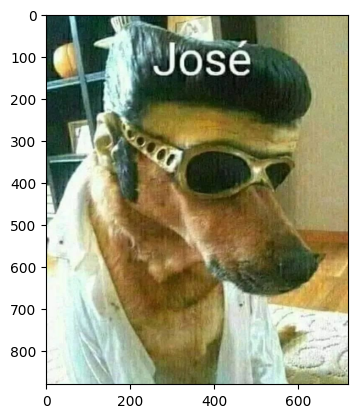

In [21]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

labels = ['cat','dog']
img = Image.open('Teste/dogs/dog_0.jpg')
plt.imshow(img)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size=(299, 299)),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047])
    ]
)
img = transform(img).to(device)
img = img.unsqueeze(0)

saved_model.eval()
pred = saved_model(img)
print(pred.softmax(dim=1))

pred = pred.argmax()

print(labels[pred])

In [23]:
from sklearn.metrics import classification_report

saved_model.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = saved_model(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        70
         1.0       0.96      0.97      0.96        70

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [22]:
from sklearn.metrics import classification_report

saved_model.train(False)

for data in val_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = saved_model(x_test)
    y_pred = y_pred.softmax(dim=1)
    print(y_pred)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    print(y_test,y_pred)

tensor([[0.8477, 0.1523],
        [0.7538, 0.2462],
        [0.8839, 0.1161],
        [0.5357, 0.4643],
        [0.6376, 0.3624],
        [0.3603, 0.6397],
        [0.0800, 0.9200],
        [0.1562, 0.8438],
        [0.0228, 0.9772],
        [0.1803, 0.8197],
        [0.0987, 0.9013],
        [0.0601, 0.9399],
        [0.0334, 0.9666],
        [0.0399, 0.9601]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
